For basic information see
 
https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo

https://en.wikipedia.org/wiki/Rejection_sampling

A simple Markov chain Monte-Carlo simulation to generate samples from t-distribution with $2$ degrees of freedom. I have implemented a random walk Metroplois-Hastings algorithm where I have used a uniform distribution on some interval $(-\delta , \delta)$ to simulate the walks. 

We have two parameters in the simulation: $\delta$ and $x_0$ ( where to start walking ). Since $t$-distribution has a density which is symmetric about $0$, so it's reasonable to choose $x_0=0$. Moreover we can expect that if $\delta$ is chosen very small, it takes longer ( needs more simulations ) to see a good estimation. Moreover if $\delta$ is very large then we may not see the convergence at all, because a $t$-distribution most likely produces samples which are in interval $(-7.5,7.5)$, therefore we don't want to have big jumps in the random walk as it might produce  many samples outside this interval.

I have shown how the estimation accuracy changes with $\delta$. In the plots, true density is the density of $t$-distribution with $2$ degrees of freedom.

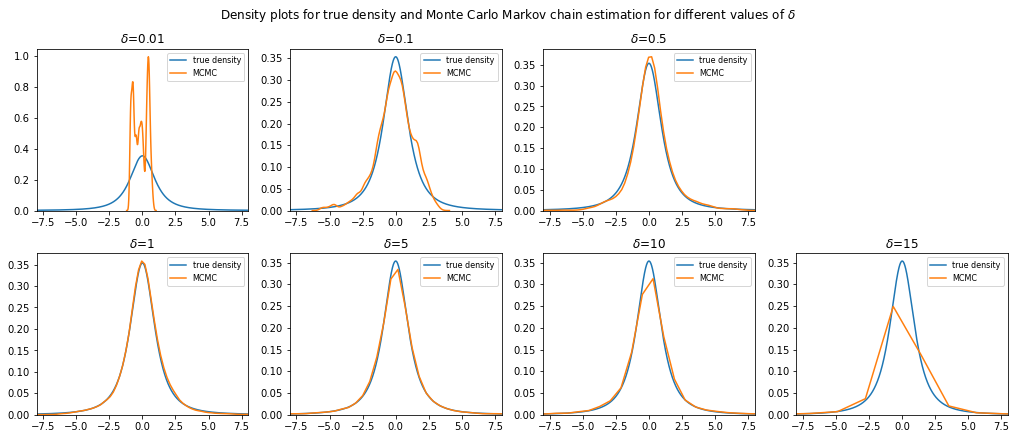

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.stats import t,norm


def Markov_Monte_Carlo(x0, delta, n_samples):
    
    x = np.zeros(n_samples)  # samples
    x[0] = x0
    
    for i in range(1,n_samples):
        
        r = np.random.uniform(-delta,delta)
        y = x[i-1] + r
        acc_ratio = min(np.log(t.pdf(y,2))-np.log(t.pdf(x[i-1],2)) , 0)  # acceptance ratio
        u = np.random.uniform(0,1)
        
        if np.log(u) < acc_ratio:
            x[i]=x[i-1]+r
        else:
            x[i]=x[i-1]
     
    return x


def MCMC_Plots(x0, delta_vec, n_samples):
    
    half = len(delta_vec)//2
    
    fig1 = plt.figure(figsize=(14,8), constrained_layout=True)
    fig1.suptitle('Density plots for true density and Monte'\
                  ' Carlo Markov chain estimation for different'\
                  ' values of $\delta$',y=1.04)
    gs1 = fig1.add_gridspec(3,4)

    for i, delta in enumerate(delta_vec[:half]):  
        
        ax = fig1.add_subplot(gs1[0, i]) 
        
        samples = Markov_Monte_Carlo(x0,delta,n_samples)
        xx = np.linspace(-8,8,n_samples)
        ax.plot(xx, t.pdf(xx,2), label='t-distribution')
        sns.kdeplot(samples, label='Metropolis simulations', ax=ax)
        ax.set_xlim([-8,8])
        ax.set_title('$\delta$={}'.format(delta))
        ax.legend(['true density','MCMC'], fontsize=8)
    
        
    for i, delta in enumerate(delta_vec[half:]):  

        ax = fig1.add_subplot(gs1[1, i]) 
        
        samples = Markov_Monte_Carlo(x0,delta,n_samples)
        xx = np.linspace(-8,8,n_samples)
        ax.plot(xx, t.pdf(xx,2), label='t-distribution')
        sns.kdeplot(samples, label='Metropolis simulations', ax=ax)
        ax.set_xlim([-8,8])
        ax.set_title('$\delta$={}'.format(delta))
        ax.legend(['true density','MCMC'], fontsize=8)
        
   
        
n_samples = 50000
x0 = 0
delta_vec = [0.01, 0.1, 0.5, 1, 5, 10, 15]
MCMC_Plots(x0, delta_vec, n_samples)


As we can see from the plots after sampling of $50000$ samples, the simulation with $\delta=1$ produces the best estimation and accuracy decreases when $\delta$ is chosen very large. For the small values of $\delta$, we need to continue the simulations to get a close approximation.

In the next cell I have implemented a different method for sampling from t-distribution with $2$ degrees of freedom. This time I have used the rejection sampling method. I have chosen a normal distribution as the candidate density and reject or accept its samples at each step with a specific probability. Here we have 3 parameters: mean and variance of normal distribution ( candidate density ) and $c$ where probability of acceptance is proportional to $\frac{1}{c}$. There are two approaches to deal with parameter $c$. In the first approach $c$ is chosen as $sup \frac{f(x)}{g(x)}$ where $f$ and $g$ are candidate and target density respectively or alternatively we can start from a initial value and update $c$ when we accept a sample. It can be shown that after some steps the value of $c$ in the second approach converges to the value in the first approach, i.e. $sup \frac{f(x)}{g(x)}$, therefore someone might find it more convenient to use the second algorithm in rejection sampling method and not bother themselves finding the supremum of that quotient. In this simulation however, I have fixed $c$ but have chosen different values of that for different simulations, to see how it affects the accuracy of simulations. Since $t$-distribution has mean $0$, so I have chosen $\mu=0$ for the mean of normal distribution.  Finally I have also used different values for $\sigma^2$, variance of normal distribution, to show how the estimation changes with the change of these parameters. 

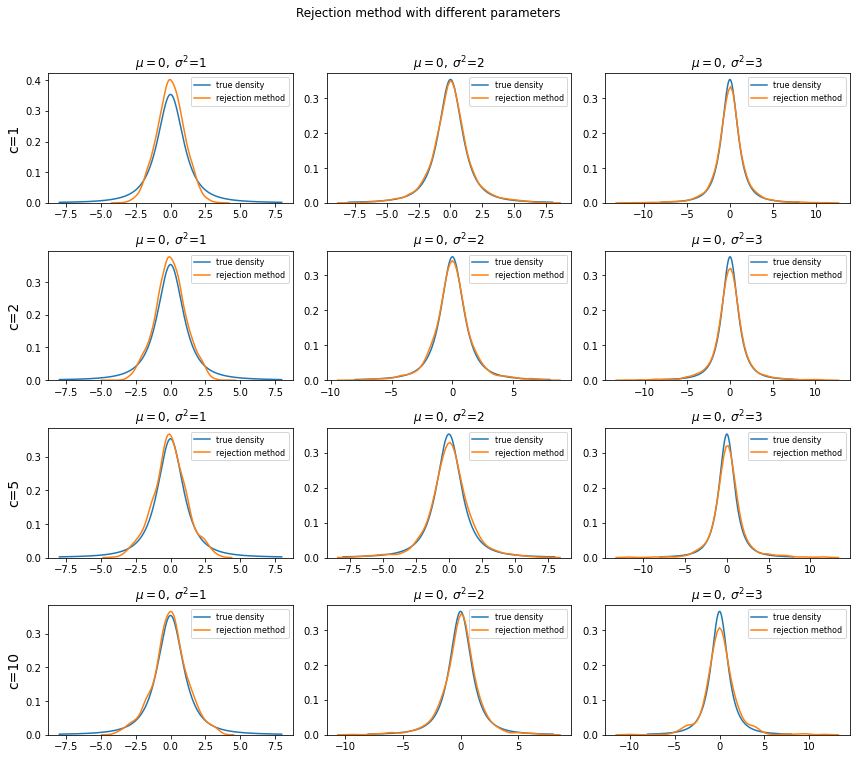

In [2]:


def rejection_sampling(norm_mean, norm_var, c, n_samples):
    
    accepted_samples=[]
    
    for i in range(n_samples):   
        u = np.random.uniform(0,1)    # or u = uniform.rvs(size=1, loc = 0, scale=1)
        n = np.random.normal(norm_mean, norm_var,1)[0]    # or n = norm.rvs(size=1,loc=0,scale=1)
        
        if u < (t.pdf(n,2))/(c*norm.pdf((n-norm_mean)/norm_var)):  # probability of acceptance = f(x)/(c g(x))
            accepted_samples.append(n) 
            
    return accepted_samples



def rs_plots(n_samples, norm_mean, var_vec, c_vec):
    
    fig, ax = plt.subplots(len(c_vec),len(var_vec),figsize=(12,10))
    xx = np.linspace(-8,8,n_samples)
    
    for i, c in enumerate(c_vec):
         for j, v in enumerate(var_vec):
    
            accepted_samples = rejection_sampling(norm_mean, v, c, n_samples,)
            ax[i,j].plot(xx, t.pdf(xx,2), label='1')
            sns.kdeplot(accepted_samples, label='2', ax=ax[i,j])
            ax[i,j].set_title('$\mu=0,\;\sigma^2$={}'.format(v),fontsize=12)
            ax[i,0].set_ylabel('c={}'.format(c), fontsize=14)
            ax[i,j].legend(['true density','rejection method'], fontsize=8)
            plt.suptitle('Rejection method with different parameters', y=1.05)
            plt.tight_layout()
            
norm_mean = 0   
n_samples = 20000
c_vec = [1,2,5,10]
var_vec = [1,2,3]

rs_plots(n_samples, norm_mean, var_vec, c_vec)


I have chosen normal distribution with mean $0$ and variance $2$ and also $c=2$ as the parameters that produces the best estimation in rejection sampling method and also $\delta=1$ as the parameter that produces the best estimation in MCMC method. Now I compare these two methods as the number of simulations changes.

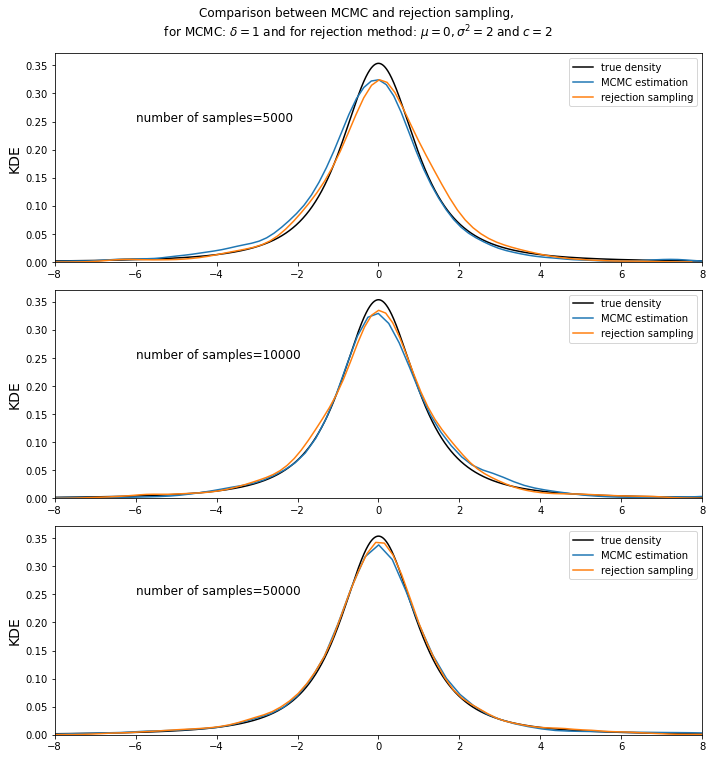

In [6]:


def Markov_Monte_Carlo(x0, delta, n_samples):
    
    x = np.zeros(n_samples)  # samples
    x[0] = x0
    
    for i in range(1,n_samples):
        
        r = np.random.uniform(-delta,delta)
        y = x[i-1] + r
        acc_ratio = min(np.log(t.pdf(y,2))-np.log(t.pdf(x[i-1],2)) , 0)
        u = np.random.uniform(0,1)
        
        if np.log(u) < acc_ratio:
            x[i]=x[i-1]+r
        else:
            x[i]=x[i-1]
     
    return x


def rejection_sampling(norm_mean, norm_var, c, n_samples):
    
    accepted_samples=[]
    
    for i in range(n_samples):   
        u = np.random.uniform(0,1)    # or u = uniform.rvs(size=1, loc = 0, scale=1)
        n = np.random.normal(norm_mean, norm_var,1)[0]    # or n = norm.rvs(size=1,loc=0,scale=1)
        
        if u < (t.pdf(n,2))/(c*norm.pdf((n-norm_mean)/norm_var)):  # probability of acceptance = f(x)/(c g(x))
            accepted_samples.append(n) 
            
    return accepted_samples




def plots(x0, delta, norm_mean, norm_var, c, list_):
    
    fig, ax = plt.subplots(len(list_), figsize=(10,10))
      
    for i, n_samples in enumerate(list_):
        
        s1 = Markov_Monte_Carlo(x0, delta, n_samples)
        s2 = rejection_sampling(norm_mean, norm_var, c, n_samples)
        xx = np.linspace(-8,8,n_samples) 
        ax[i].plot(xx, t.pdf(xx,2), label='1', color='black')
        sns.kdeplot(s1, label='1', ax=ax[i])
        sns.kdeplot(s2, label='2', ax=ax[i])
        ax[i].set_xlim([-8,8])
        ax[i].text(-6,0.25,'number of samples={}'.format(n_samples), fontsize=12)
        ax[i].set_ylabel('KDE', fontsize=14)
        ax[i].legend(['true density','MCMC estimation','rejection sampling'], fontsize=10)
        plt.suptitle('Comparison between MCMC and rejection sampling,\n for MCMC:'\
                    ' $\delta=1$ and for rejection method: $\mu=0,\sigma^2=2$ and $c=2$', y=1.05)
        plt.tight_layout()
    
    
x0 = 0
delta = 1  
norm_mean = 0   
norm_var = 2
c = 2
list_ = [5000,10000,50000]

plots(x0, delta, norm_mean, norm_var, c, list_)

We can see that with a good choice of paramaters for both methods, we have a close approximation after $50000$ simulations.